# Set up

In [1]:
import torchreid
from torchreid.data.datasets.image.til2023_cv_test import Til2023CvTest
torchreid.data.register_image_dataset('til2023_cv_test', Til2023CvTest)

/notebooks/deep-person-reid/torchreid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


In [2]:
datamanager = torchreid.data.ImageDataManager(
    root='reid-data',
    sources='til2023_cv_test'
)

Building train transforms ...
+ resize to 256x128
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
TRAIN:::  [('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00066_5618.png', 66, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00175_3145.png', 175, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00158_5614.png', 158, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00060_4026.png', 60, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00156_4167.png', 156, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00107_3907.png', 107, 0), ('/notebooks/deep-person-reid/reid-data/til2023_cv_dataset/Train1/00067_2344.png

# Assemble Model

## model 1 - resnet50

In [4]:
model = torchreid.models.build_model(
    name="resnet50",
    num_classes=datamanager.num_train_pids,
    loss="softmax",
    pretrained=True
)

model = model.cuda()

optimizer = torchreid.optim.build_optimizer(
    model,
    optim="adam",
    lr=0.0003
)

scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler="single_step",
    stepsize=20
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## mode 2 - resnet50mid

## model 4 - osnet_ain_x0_1

In [32]:
model = torchreid.models.build_model(
    name="osnet_ain_x1_0",
    num_classes=datamanager.num_train_pids,
    loss="softmax",
    pretrained=True
)

model = model.cuda()

optimizer = torchreid.optim.build_optimizer(
    model,
    optim="adam",
    lr=0.0015,
)

scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler="single_step",
    stepsize=20
)

Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


## model 5 - osnet_ain_x0_25

In [12]:
model = torchreid.models.build_model(
    name="osnet_ain_x0_25",
    num_classes=datamanager.num_train_pids,
    loss="softmax",
    pretrained=True
)

model = model.cuda()

optimizer = torchreid.optim.build_optimizer(
    model,
    optim="adam",
    lr=0.0003
)

scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler="single_step",
    stepsize=20
)

Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_ain_x0_25_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


# Assemble engine, load weights

In [37]:
engine = torchreid.engine.ImageSoftmaxEngine(
    datamanager,
    model,
    optimizer=optimizer,
    scheduler=scheduler,
    label_smooth=True
)

In [38]:
from torchreid.utils import load_pretrained_weights

In [39]:
weight_path = '/notebooks/deep-person-reid/log/til_osnet_ain_x1_0/model/model.pth.tar-12-95.7'

In [40]:
load_pretrained_weights(model, weight_path)

Successfully loaded pretrained weights from "/notebooks/deep-person-reid/log/til_osnet_ain_x1_0/model/model.pth.tar-12-95.7"


In [41]:
_,distmat, queries_and_galley = engine.run(
    save_dir="log/til_resnet50",
    max_epoch=4,
    eval_freq=1,
    print_freq=50,
    test_only=True
)

##### Evaluating til2023_cv_test (source) #####
Extracting features from query set ...
HELLO HERE ARE UR PIDS AND CAMIDS: 
[0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]
Done, obtained 1600-by-512 matrix
Extracting features from gallery set ...
HELLO HERE ARE UR PIDS AND CAMIDS: 
[0 0 0 ... 0 0 0] [2 2 2 ... 2 2 2]
Done, obtained 3406-by-512 matrix
Speed: 0.0182 sec/batch
Computing distance matrix with metric=euclidean ...
YOUR DISTMAT!!!:  (1600, 3406)
[157.2289  122.99136 188.97482 ... 202.46722 165.00577 166.95863]
[188.14027 141.12283 213.39738 ... 228.58356 238.9758  120.41783]
[140.51514 175.06915 195.23296 ... 228.9751  239.23071 149.69983]
[239.53136 189.50908 171.10143 ... 231.5986  235.40033 193.4367 ]
[166.63062 194.8921  192.51337 ... 203.39731 205.80927 175.04602]
[215.42236 169.45222 164.04535 ... 241.15283 226.75128 181.45984]
[242.80476 180.86682 186.3118  ... 253.5545  241.58574 238.44987]
[212.85454 202.23375 185.16026 ... 238.55649 180.29959 255.44966]
[188.66385 153.0861  222.

# post process results

In [42]:
from PIL import Image

In [43]:
def visualise_matches(d, q, index):
    query = q[0][index][0]
    distmat = d[index]
    gallery = q[1]
    
    temp = zip(distmat, gallery)
    print("#SUS ", query)
    im=Image.open(query)
    im.show()
    for i in sorted(temp):
        if query[-8:-4] in i[1][0][-13:-8]:
            print("#CANDIDATES: ", i)
            im=Image.open(i[1][0])
            im.show()

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0062.png


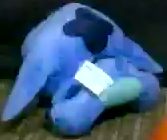

#CANDIDATES:  (66.39462, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0062_0128.png', 0, 2, 0))


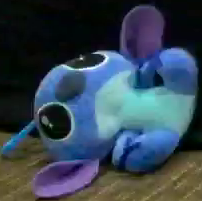

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0171.png


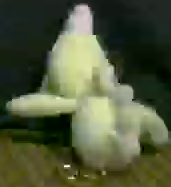

#CANDIDATES:  (141.19185, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0171_0346.png', 0, 2, 0))


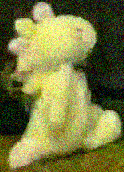

#CANDIDATES:  (213.1421, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0171_0347.png', 0, 2, 0))


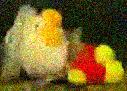

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1568.png


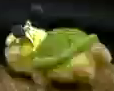

#CANDIDATES:  (50.189278, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1568_3334.png', 0, 2, 0))


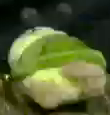

#CANDIDATES:  (175.01402, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1568_3333.png', 0, 2, 0))


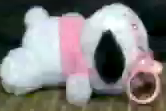

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1310.png


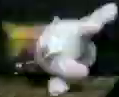

#CANDIDATES:  (53.88744, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1310_2788.png', 0, 2, 0))


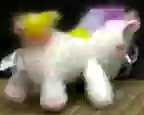

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0835.png


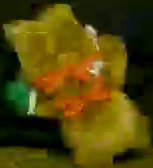

#CANDIDATES:  (129.74544, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0835_1787.png', 0, 2, 0))


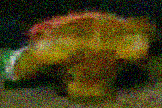

#CANDIDATES:  (172.24261, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0835_1785.png', 0, 2, 0))


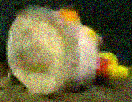

#CANDIDATES:  (178.82742, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0835_1786.png', 0, 2, 0))


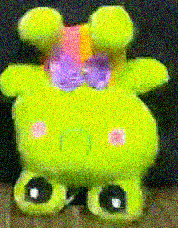

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0216.png


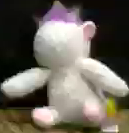

#CANDIDATES:  (121.58896, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0216_0444.png', 0, 2, 0))


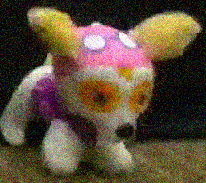

#CANDIDATES:  (214.14452, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0216_0446.png', 0, 2, 0))


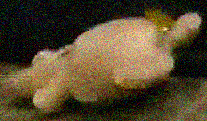

#CANDIDATES:  (234.4654, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0216_0445.png', 0, 2, 0))


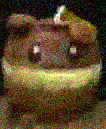

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0458.png


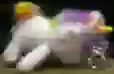

#CANDIDATES:  (118.53427, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0458_0971.png', 0, 2, 0))


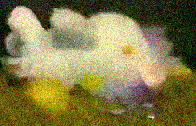

#CANDIDATES:  (215.73392, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0458_0972.png', 0, 2, 0))


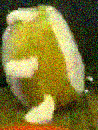

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1585.png


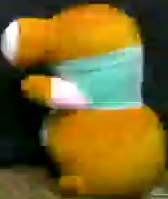

#CANDIDATES:  (229.28703, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1585_3372.png', 0, 2, 0))


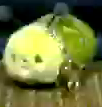

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1032.png


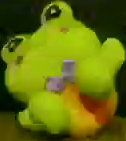

#CANDIDATES:  (226.67355, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1032_2206.png', 0, 2, 0))


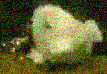

#CANDIDATES:  (241.78438, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1032_2207.png', 0, 2, 0))


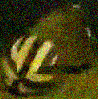

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0710.png


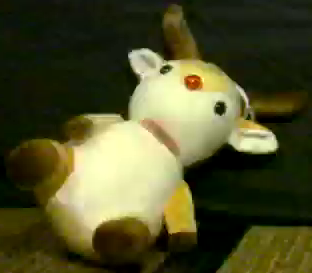

#CANDIDATES:  (177.362, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0710_1513.png', 0, 2, 0))


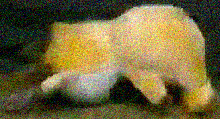

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0892.png


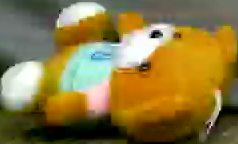

#CANDIDATES:  (73.83487, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0892_1896.png', 0, 2, 0))


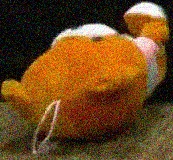

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1519.png


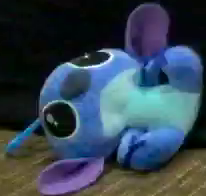

#CANDIDATES:  (96.96126, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1519_3228.png', 0, 2, 0))


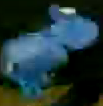

#CANDIDATES:  (153.90355, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1519_3226.png', 0, 2, 0))


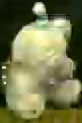

#CANDIDATES:  (213.736, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1519_3227.png', 0, 2, 0))


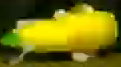

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1135.png


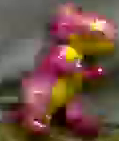

#CANDIDATES:  (176.775, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1135_2435.png', 0, 2, 0))


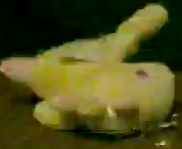

#CANDIDATES:  (188.86946, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1135_2434.png', 0, 2, 0))


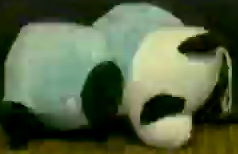

#CANDIDATES:  (213.5662, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1135_2436.png', 0, 2, 0))


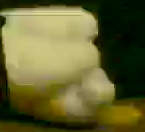

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0358.png


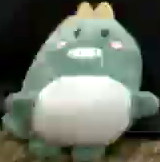

#CANDIDATES:  (96.05941, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0358_0746.png', 0, 2, 0))


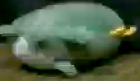

#CANDIDATES:  (207.72627, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0358_0745.png', 0, 2, 0))


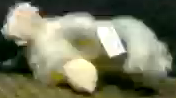

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0021.png


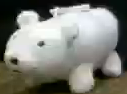

#CANDIDATES:  (91.926445, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0021_0047.png', 0, 2, 0))


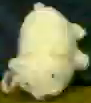

#CANDIDATES:  (162.82321, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0021_0048.png', 0, 2, 0))


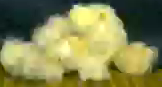

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1219.png


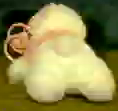

#CANDIDATES:  (104.75353, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1219_2612.png', 0, 2, 0))


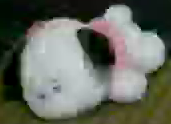

#CANDIDATES:  (251.18555, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1219_2611.png', 0, 2, 0))


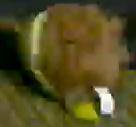

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0872.png


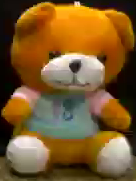

#CANDIDATES:  (58.638622, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0872_1857.png', 0, 2, 0))


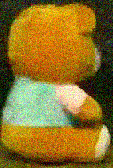

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0300.png


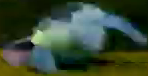

#CANDIDATES:  (39.61283, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0300_0616.png', 0, 2, 0))


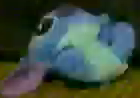

#CANDIDATES:  (40.617783, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0300_0615.png', 0, 2, 0))


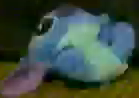

#CANDIDATES:  (151.29895, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0300_0617.png', 0, 2, 0))


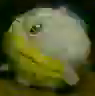

#CANDIDATES:  (217.51717, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0300_0614.png', 0, 2, 0))


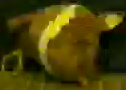

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0189.png


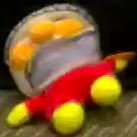

#CANDIDATES:  (53.42737, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0189_0388.png', 0, 2, 0))


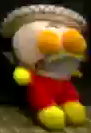

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0455.png


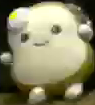

#CANDIDATES:  (121.491776, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0455_0966.png', 0, 2, 0))


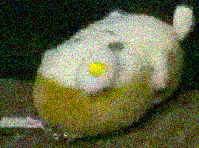

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0789.png


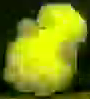

#CANDIDATES:  (206.19801, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0789_1679.png', 0, 2, 0))


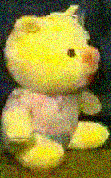

#CANDIDATES:  (234.10968, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0789_1680.png', 0, 2, 0))


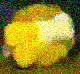

#CANDIDATES:  (235.3284, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0789_1681.png', 0, 2, 0))


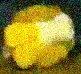

#CANDIDATES:  (262.8168, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0789_1678.png', 0, 2, 0))


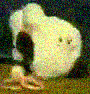

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0105.png


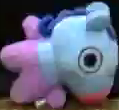

#CANDIDATES:  (142.87094, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0105_0213.png', 0, 2, 0))


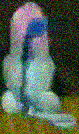

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0435.png


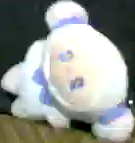

#CANDIDATES:  (72.418106, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0435_0912.png', 0, 2, 0))


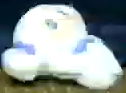

#CANDIDATES:  (154.64905, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0435_0910.png', 0, 2, 0))


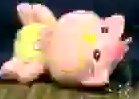

#CANDIDATES:  (271.57944, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0435_0911.png', 0, 2, 0))


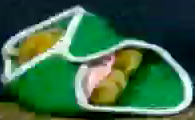

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0952.png


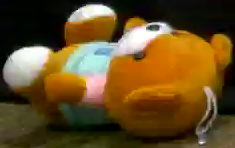

#CANDIDATES:  (47.09147, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0952_2037.png', 0, 2, 0))


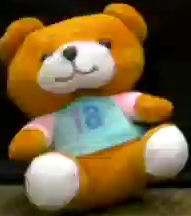

#CANDIDATES:  (127.31821, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0952_2035.png', 0, 2, 0))


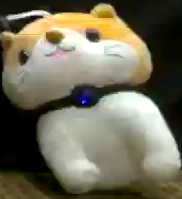

#CANDIDATES:  (187.83922, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0952_2036.png', 0, 2, 0))


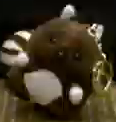

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0808.png


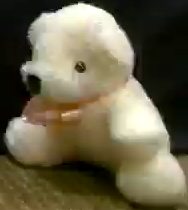

#CANDIDATES:  (109.88178, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0808_1725.png', 0, 2, 0))


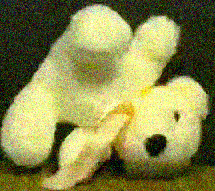

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0712.png


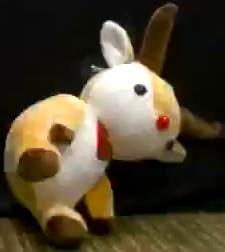

#CANDIDATES:  (29.469551, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0712_1518.png', 0, 2, 0))


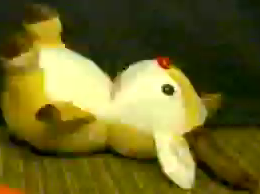

#CANDIDATES:  (169.90683, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0712_1517.png', 0, 2, 0))


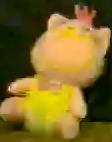

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0395.png


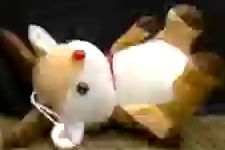

#CANDIDATES:  (198.93358, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0395_0825.png', 0, 2, 0))


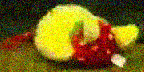

#CANDIDATES:  (226.65923, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0395_0824.png', 0, 2, 0))


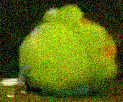

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1079.png


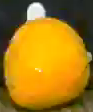

#CANDIDATES:  (142.57259, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1079_2315.png', 0, 2, 0))


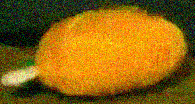

#CANDIDATES:  (261.3609, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1079_2314.png', 0, 2, 0))


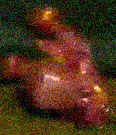

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_0982.png


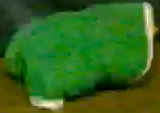

#CANDIDATES:  (159.21744, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0982_2099.png', 0, 2, 0))


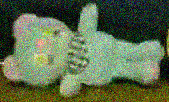

#CANDIDATES:  (169.41327, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0982_2100.png', 0, 2, 0))


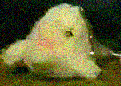

#CANDIDATES:  (234.76329, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_0982_2098.png', 0, 2, 0))


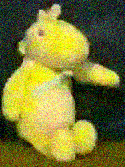

#SUS  /notebooks/deep-person-reid/reid-data/til2023_cv_test/Suspects/image_1103.png


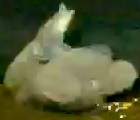

#CANDIDATES:  (158.30666, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1103_2367.png', 0, 2, 0))


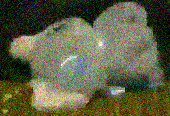

#CANDIDATES:  (211.74763, ('/notebooks/deep-person-reid/reid-data/til2023_cv_test/Test1/image_1103_2368.png', 0, 2, 0))


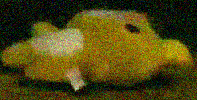

In [51]:
for i in range(30):
    visualise_matches(distmat, queries_and_galley, i)

In [68]:
def output_matches(d, q, index):
    query = q[0][index][0]
    distmat = d[index]
    gallery = q[1]
    
    temp = zip(distmat, gallery)
    # print(query)
    # im=Image.open(query)
    # im.show()
    
    output = {}
    for i in sorted(temp):
        if query[-8:-4] in i[1][0][-13:-8]:
            if i[0] < 170 and output == {}:
                output[int(i[1][0][-8:-4])] = 1
            else:
                output[int(i[1][0][-8:-4])] = 0
                
    return output

In [69]:
import pandas as pd
from pandas import DataFrame
path = "/notebooks/deep-person-reid/reid-data/dataepoch2.csv"
df = pd.read_csv(path)
df.head(10)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,image_0000,0,0.956654,0.668310,0.458844,0.802455,0.544721
1,image_0000,0,0.926381,0.644173,0.139925,0.779620,0.221009
2,image_0000,0,0.921721,0.632702,0.248414,0.782471,0.334031
3,image_0001,0,0.957138,0.741689,0.697222,0.884431,0.814440
4,image_0001,0,0.950481,0.590011,0.391353,0.951974,0.528478
5,image_0001,0,0.948515,0.729235,0.153742,0.888728,0.266504
6,image_0002,0,0.959682,0.705045,0.564205,0.896992,0.663039
7,image_0002,0,0.953128,0.698485,0.333341,0.859158,0.448662
8,image_0002,0,0.952899,0.720116,0.748604,0.874441,0.868367
9,image_0003,0,0.959391,0.634337,0.693626,0.927256,0.857668


In [70]:
for i in range(1600):
    output = output_matches(distmat, queries_and_galley, i)
    for j in output.keys():
        df.at[j,"class"] = output[j]

In [71]:
df.head(40)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,image_0000,0,0.956654,0.668310,0.458844,0.802455,0.544721
1,image_0000,0,0.926381,0.644173,0.139925,0.779620,0.221009
2,image_0000,1,0.921721,0.632702,0.248414,0.782471,0.334031
3,image_0001,1,0.957138,0.741689,0.697222,0.884431,0.814440
4,image_0001,0,0.950481,0.590011,0.391353,0.951974,0.528478
5,image_0001,0,0.948515,0.729235,0.153742,0.888728,0.266504
6,image_0002,1,0.959682,0.705045,0.564205,0.896992,0.663039
7,image_0002,0,0.953128,0.698485,0.333341,0.859158,0.448662
8,image_0002,0,0.952899,0.720116,0.748604,0.874441,0.868367
9,image_0003,0,0.959391,0.634337,0.693626,0.927256,0.857668


In [72]:
df.to_csv("/notebooks/file_transfer/submission_8.csv")